In [1]:
import torch
from PIL import Image
from torchvision import transforms
import os
import torch.nn.functional as F

from tqdm import tqdm
import torchvision
from torchvision.io import read_image, ImageReadMode
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset, RandomSampler

import warnings
warnings.filterwarnings('ignore')


import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

import random
import shutil

from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
import skimage.io as io

import torch
import torch.nn as nn
from torch.nn.init import trunc_normal_
from torch.nn.utils import weight_norm


class DINOHead(nn.Module):
    def __init__(
        self,
        in_dim,
        out_dim,
        use_bn=False,
        nlayers=3,
        hidden_dim=2048,
        bottleneck_dim=256,
        mlp_bias=True,
    ):
        super().__init__()
        nlayers = max(nlayers, 1)
        self.mlp = _build_mlp(nlayers, in_dim, bottleneck_dim, hidden_dim=hidden_dim, use_bn=use_bn, bias=mlp_bias)
        self.apply(self._init_weights)
        self.last_layer = weight_norm(nn.Linear(bottleneck_dim, out_dim, bias=False))
        self.last_layer.weight_g.data.fill_(1)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.mlp(x)
        eps = 1e-6 if x.dtype == torch.float16 else 1e-12
        x = nn.functional.normalize(x, dim=-1, p=2, eps=eps)
        x = self.last_layer(x)
        return x


def _build_mlp(nlayers, in_dim, bottleneck_dim, hidden_dim=None, use_bn=False, bias=True):
    if nlayers == 1:
        return nn.Linear(in_dim, bottleneck_dim, bias=bias)
    else:
        layers = [nn.Linear(in_dim, hidden_dim, bias=bias)]
        if use_bn:
            layers.append(nn.BatchNorm1d(hidden_dim))
        layers.append(nn.GELU())
        for _ in range(nlayers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim, bias=bias))
            if use_bn:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.GELU())
        layers.append(nn.Linear(hidden_dim, bottleneck_dim, bias=bias))
        return nn.Sequential(*layers)
    

dinov2_vits14_lc = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_lc')
dinov2_vits14_lc_batch9=dinov2_vits14_lc
dinov2_vits14_lc_batch9.linear_head=DINOHead(in_dim=1920,out_dim=4)

Using cache found in /Users/xiatian2/.cache/torch/hub/facebookresearch_dinov2_main


In [2]:
dinov2_vits14_lc_batch9

_LinearClassifierWrapper(
  (backbone): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=Fals

In [7]:
model = dinov2_vits14_lc_batch9
model.load_state_dict(torch.load('/Users/xiatian2/VIT/dinov2_vits14_reg4_linear4_head.pth'))
model

RuntimeError: Error(s) in loading state_dict for _LinearClassifierWrapper:
	Missing key(s) in state_dict: "backbone.cls_token", "backbone.pos_embed", "backbone.mask_token", "backbone.patch_embed.proj.weight", "backbone.patch_embed.proj.bias", "backbone.blocks.0.norm1.weight", "backbone.blocks.0.norm1.bias", "backbone.blocks.0.attn.qkv.weight", "backbone.blocks.0.attn.qkv.bias", "backbone.blocks.0.attn.proj.weight", "backbone.blocks.0.attn.proj.bias", "backbone.blocks.0.ls1.gamma", "backbone.blocks.0.norm2.weight", "backbone.blocks.0.norm2.bias", "backbone.blocks.0.mlp.fc1.weight", "backbone.blocks.0.mlp.fc1.bias", "backbone.blocks.0.mlp.fc2.weight", "backbone.blocks.0.mlp.fc2.bias", "backbone.blocks.0.ls2.gamma", "backbone.blocks.1.norm1.weight", "backbone.blocks.1.norm1.bias", "backbone.blocks.1.attn.qkv.weight", "backbone.blocks.1.attn.qkv.bias", "backbone.blocks.1.attn.proj.weight", "backbone.blocks.1.attn.proj.bias", "backbone.blocks.1.ls1.gamma", "backbone.blocks.1.norm2.weight", "backbone.blocks.1.norm2.bias", "backbone.blocks.1.mlp.fc1.weight", "backbone.blocks.1.mlp.fc1.bias", "backbone.blocks.1.mlp.fc2.weight", "backbone.blocks.1.mlp.fc2.bias", "backbone.blocks.1.ls2.gamma", "backbone.blocks.2.norm1.weight", "backbone.blocks.2.norm1.bias", "backbone.blocks.2.attn.qkv.weight", "backbone.blocks.2.attn.qkv.bias", "backbone.blocks.2.attn.proj.weight", "backbone.blocks.2.attn.proj.bias", "backbone.blocks.2.ls1.gamma", "backbone.blocks.2.norm2.weight", "backbone.blocks.2.norm2.bias", "backbone.blocks.2.mlp.fc1.weight", "backbone.blocks.2.mlp.fc1.bias", "backbone.blocks.2.mlp.fc2.weight", "backbone.blocks.2.mlp.fc2.bias", "backbone.blocks.2.ls2.gamma", "backbone.blocks.3.norm1.weight", "backbone.blocks.3.norm1.bias", "backbone.blocks.3.attn.qkv.weight", "backbone.blocks.3.attn.qkv.bias", "backbone.blocks.3.attn.proj.weight", "backbone.blocks.3.attn.proj.bias", "backbone.blocks.3.ls1.gamma", "backbone.blocks.3.norm2.weight", "backbone.blocks.3.norm2.bias", "backbone.blocks.3.mlp.fc1.weight", "backbone.blocks.3.mlp.fc1.bias", "backbone.blocks.3.mlp.fc2.weight", "backbone.blocks.3.mlp.fc2.bias", "backbone.blocks.3.ls2.gamma", "backbone.blocks.4.norm1.weight", "backbone.blocks.4.norm1.bias", "backbone.blocks.4.attn.qkv.weight", "backbone.blocks.4.attn.qkv.bias", "backbone.blocks.4.attn.proj.weight", "backbone.blocks.4.attn.proj.bias", "backbone.blocks.4.ls1.gamma", "backbone.blocks.4.norm2.weight", "backbone.blocks.4.norm2.bias", "backbone.blocks.4.mlp.fc1.weight", "backbone.blocks.4.mlp.fc1.bias", "backbone.blocks.4.mlp.fc2.weight", "backbone.blocks.4.mlp.fc2.bias", "backbone.blocks.4.ls2.gamma", "backbone.blocks.5.norm1.weight", "backbone.blocks.5.norm1.bias", "backbone.blocks.5.attn.qkv.weight", "backbone.blocks.5.attn.qkv.bias", "backbone.blocks.5.attn.proj.weight", "backbone.blocks.5.attn.proj.bias", "backbone.blocks.5.ls1.gamma", "backbone.blocks.5.norm2.weight", "backbone.blocks.5.norm2.bias", "backbone.blocks.5.mlp.fc1.weight", "backbone.blocks.5.mlp.fc1.bias", "backbone.blocks.5.mlp.fc2.weight", "backbone.blocks.5.mlp.fc2.bias", "backbone.blocks.5.ls2.gamma", "backbone.blocks.6.norm1.weight", "backbone.blocks.6.norm1.bias", "backbone.blocks.6.attn.qkv.weight", "backbone.blocks.6.attn.qkv.bias", "backbone.blocks.6.attn.proj.weight", "backbone.blocks.6.attn.proj.bias", "backbone.blocks.6.ls1.gamma", "backbone.blocks.6.norm2.weight", "backbone.blocks.6.norm2.bias", "backbone.blocks.6.mlp.fc1.weight", "backbone.blocks.6.mlp.fc1.bias", "backbone.blocks.6.mlp.fc2.weight", "backbone.blocks.6.mlp.fc2.bias", "backbone.blocks.6.ls2.gamma", "backbone.blocks.7.norm1.weight", "backbone.blocks.7.norm1.bias", "backbone.blocks.7.attn.qkv.weight", "backbone.blocks.7.attn.qkv.bias", "backbone.blocks.7.attn.proj.weight", "backbone.blocks.7.attn.proj.bias", "backbone.blocks.7.ls1.gamma", "backbone.blocks.7.norm2.weight", "backbone.blocks.7.norm2.bias", "backbone.blocks.7.mlp.fc1.weight", "backbone.blocks.7.mlp.fc1.bias", "backbone.blocks.7.mlp.fc2.weight", "backbone.blocks.7.mlp.fc2.bias", "backbone.blocks.7.ls2.gamma", "backbone.blocks.8.norm1.weight", "backbone.blocks.8.norm1.bias", "backbone.blocks.8.attn.qkv.weight", "backbone.blocks.8.attn.qkv.bias", "backbone.blocks.8.attn.proj.weight", "backbone.blocks.8.attn.proj.bias", "backbone.blocks.8.ls1.gamma", "backbone.blocks.8.norm2.weight", "backbone.blocks.8.norm2.bias", "backbone.blocks.8.mlp.fc1.weight", "backbone.blocks.8.mlp.fc1.bias", "backbone.blocks.8.mlp.fc2.weight", "backbone.blocks.8.mlp.fc2.bias", "backbone.blocks.8.ls2.gamma", "backbone.blocks.9.norm1.weight", "backbone.blocks.9.norm1.bias", "backbone.blocks.9.attn.qkv.weight", "backbone.blocks.9.attn.qkv.bias", "backbone.blocks.9.attn.proj.weight", "backbone.blocks.9.attn.proj.bias", "backbone.blocks.9.ls1.gamma", "backbone.blocks.9.norm2.weight", "backbone.blocks.9.norm2.bias", "backbone.blocks.9.mlp.fc1.weight", "backbone.blocks.9.mlp.fc1.bias", "backbone.blocks.9.mlp.fc2.weight", "backbone.blocks.9.mlp.fc2.bias", "backbone.blocks.9.ls2.gamma", "backbone.blocks.10.norm1.weight", "backbone.blocks.10.norm1.bias", "backbone.blocks.10.attn.qkv.weight", "backbone.blocks.10.attn.qkv.bias", "backbone.blocks.10.attn.proj.weight", "backbone.blocks.10.attn.proj.bias", "backbone.blocks.10.ls1.gamma", "backbone.blocks.10.norm2.weight", "backbone.blocks.10.norm2.bias", "backbone.blocks.10.mlp.fc1.weight", "backbone.blocks.10.mlp.fc1.bias", "backbone.blocks.10.mlp.fc2.weight", "backbone.blocks.10.mlp.fc2.bias", "backbone.blocks.10.ls2.gamma", "backbone.blocks.11.norm1.weight", "backbone.blocks.11.norm1.bias", "backbone.blocks.11.attn.qkv.weight", "backbone.blocks.11.attn.qkv.bias", "backbone.blocks.11.attn.proj.weight", "backbone.blocks.11.attn.proj.bias", "backbone.blocks.11.ls1.gamma", "backbone.blocks.11.norm2.weight", "backbone.blocks.11.norm2.bias", "backbone.blocks.11.mlp.fc1.weight", "backbone.blocks.11.mlp.fc1.bias", "backbone.blocks.11.mlp.fc2.weight", "backbone.blocks.11.mlp.fc2.bias", "backbone.blocks.11.ls2.gamma", "backbone.norm.weight", "backbone.norm.bias", "linear_head.mlp.0.weight", "linear_head.mlp.0.bias", "linear_head.mlp.2.weight", "linear_head.mlp.2.bias", "linear_head.mlp.4.weight", "linear_head.mlp.4.bias", "linear_head.last_layer.weight_g", "linear_head.last_layer.weight_v". 
	Unexpected key(s) in state_dict: "weight", "bias". 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4117647..7.4117646].


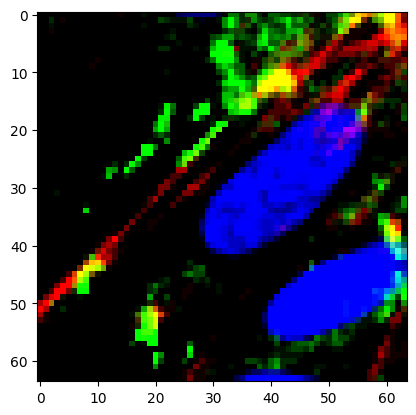

In [9]:
file_path='/Users/xiatian2/VIT/batch9/train/raw/WellA2_PointA2_0241_ChannelPhalloAF750,ZO1-AF488,DAPI_Seq1266.ome.tiff'
x_before = io.imread(file_path)
x_before=Image.fromarray((x_before / 256).astype('uint8')).convert('RGB')

mean = (0.03, 0.08, 0.02) 
std = (0.02, 0.04, 0.04)
#mean = (-0.1, -0.1, -0.1)
#std = (0.6, 0.6, 0.6)

random.seed(100)
torch.manual_seed(100)
val_transform = transforms.Compose(
            [   
                transforms.RandomCrop(size=(64,64)),
                #transforms.Resize(256),
                #transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
x_after = val_transform(x_before)
plt.imshow(x_after.permute(1, 2, 0))
plt.show()

In [8]:
from torch.utils.data import Dataset
import json
tar_dic={'WellA1':0,'WellA2':1,'WellA3':2,'WellB1':3}
class AMDEMTBatch9(Dataset):
    def __init__(self, root, split, transform=None):
        self.samples = []
        self.targets = []
        self.transform = transform
        samples_dir = os.path.join(root, split,'raw') # the file dir is constructed as your_dir / train(test) / raw / ..ome.tiff
        for entry in os.listdir(samples_dir):
            if entry.endswith('.tiff'):
                if split == "val":
                    sample_path = os.path.join(samples_dir, entry)
                    self.samples.append(sample_path)
                    self.targets.append(tar_dic[entry.split('_')[0]])
                elif split == "train":
                    sample_path = os.path.join(samples_dir, entry)
                    self.samples.append(sample_path)
                    self.targets.append(tar_dic[entry.split('_')[0]])
    def __len__(self):
            return len(self.samples)
    def __getitem__(self, idx):
            x = io.imread(self.samples[idx])
            x = Image.fromarray((x / 256).astype('uint8')).convert('RGB')
            if self.transform:
                x = self.transform(x)
            return x, self.targets[idx]
    

mean = (0.03, 0.08, 0.02)
std = (0.02, 0.04, 0.04)

model=dinov2_vits14_lc_batch9

data_transforms = {
'train': transforms.Compose(
            [   
                transforms.RandomCrop(size=(250,250)),
                transforms.RandomHorizontalFlip(),
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        ),
'val': transforms.Compose(
            [   
                transforms.RandomCrop(size=(250,250)),
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )}
image_datasets = {x: AMDEMTBatch9('/Users/xiatian2/VIT/batch9', x, data_transforms[x])
                  for x in ['train', 'val']}

sampler = {x: RandomSampler(image_datasets[x], replacement=True, num_samples=200)
              for x in ['train', 'val']}
dataloaders = {x: DataLoader(dataset=image_datasets[x], sampler=sampler[x],batch_size=4,drop_last=True)
              for x in ['train', 'val']}


correct = 0
total = 0
'''
with torch.no_grad():
    for x, y in tqdm(dataloaders['val']):
        y_pred = model(x)
        correct += (y_pred.argmax(axis=1) == y).sum().item()
        total += len(y)
        
print(correct / total)
'''

"\nwith torch.no_grad():\n    for x, y in tqdm(dataloaders['val']):\n        y_pred = model(x)\n        correct += (y_pred.argmax(axis=1) == y).sum().item()\n        total += len(y)\n        \nprint(correct / total)\n"

In [9]:
#optimize whole network
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
#scheduler= optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

epochs = 20

#for param in model.parameters():
#    param.requires_grad = False
#num_ftrs = model.linear_head.in_features
#model.linear_head = nn.Linear(num_ftrs, 4)

best_acc=0.0
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs - 1}')
    print('-' * 10)
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode
        
        running_loss,running_corrects,total=0,0,0
        for x, y in dataloaders[phase]:
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                output = model(x)
                _, preds = torch.max(output, 1)
                loss = criterion(output, y)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            
            running_loss += loss.item() * x.size(0)
            running_corrects += torch.sum(preds == y.data)
            total += len(y)
        #if phase == 'train':    
           # scheduler.step()
        epoch_loss = running_loss / total
        epoch_acc = running_corrects.double() / total

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), '10epoch_fewshot_dinov2_vits14_lc_batch9.pth')

print(f'Best val Acc: {best_acc:4f}')

Epoch 0/19
----------
train Loss: 1.4177 Acc: 0.2250
val Loss: 1.3985 Acc: 0.2400
Epoch 1/19
----------
train Loss: 1.4038 Acc: 0.2200
val Loss: 1.3834 Acc: 0.2850
Epoch 2/19
----------
train Loss: 1.4047 Acc: 0.2100
val Loss: 1.3846 Acc: 0.2700
Epoch 3/19
----------
train Loss: 1.3900 Acc: 0.2200
val Loss: 1.3945 Acc: 0.2300
Epoch 4/19
----------
train Loss: 1.3893 Acc: 0.2350
val Loss: 1.3904 Acc: 0.2500
Epoch 5/19
----------
train Loss: 1.3918 Acc: 0.2350
val Loss: 1.3937 Acc: 0.2350
Epoch 6/19
----------


KeyboardInterrupt: 